# NLP Disasters Mini Project
**Course:** CSCA 5642
**Date:** Dec 2025

In [2]:
# Basic Libs
import pandas as pd
import numpy as np
import string, os, re, hashlib
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Force CPU to avoid CUDA 12.0 errors with RTX 5090

# Plotting Libs
import seaborn as sns
import matplotlib.pyplot as plt

# NLP Libs
import nltk
# NLTK One-Time Downloads
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Embedding Libs
from gensim.models import Word2Vec, FastText

# Linear Model Libs
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score

# Neural Network Libs
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


2025-12-08 19:19:18.563778: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 19:19:18.731144: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 19:19:19.461392: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
stop_words = set(stopwords.words('english'))
punct_table = str.maketrans('', '', string.punctuation)
lemmatizer = WordNetLemmatizer()

def clean_pos_lemma(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text.lower())
    tokens = text.translate(punct_table).split()
    tagged = nltk.pos_tag(tokens)
    return ' '.join(lemmatizer.lemmatize(w, pos=wordnet.ADJ if t.startswith('J')
                                         else wordnet.VERB if t.startswith('V')
                                         else wordnet.NOUN if t.startswith('N')
                                         else wordnet.ADV if t.startswith('R')
                                         else wordnet.NOUN)
                    for w, t in tagged)

def clean_light(text):
    # minimal cleaning; keeps punctuation/hashtags/mentions for n-grams
    return re.sub(r'http\S+|www\S+|https\S+', '', text.lower())

def clean_char_preserve(text):
    # for char n-grams; almost no cleaning
    return text.lower()

CLEANERS = {
    'pos_lemma': clean_pos_lemma,
    'light': clean_light,
    'char_keep': clean_char_preserve,
}

## Data & Preprocessing

In [4]:
class DisasterData:
    def __init__(self, path: str, val_size=0.2, random_state=11):
        full_train = pd.read_csv(f'{path}/train.csv')
        self.test_df = pd.read_csv(f'{path}/test.csv')
        self.train_df, self.val_df = train_test_split(
            full_train, test_size=val_size, random_state=random_state, stratify=full_train['target']
        )
        self._clean_cache = {} 

    def get_split(self, cleaner_name: str):
        """Return cleaned splits for the requested cleaner; caches to avoid recompute."""
        if cleaner_name not in CLEANERS:
            raise ValueError(f'Unknown cleaner {cleaner_name}')
        if cleaner_name not in self._clean_cache:
            fn = CLEANERS[cleaner_name]
            self._clean_cache[cleaner_name] = (
                self.train_df['text'].apply(fn),
                self.val_df['text'].apply(fn),
                self.test_df['text'].apply(fn),
            )
        X_train, X_val, X_test = self._clean_cache[cleaner_name]
        return {
            'X_train': X_train,
            'y_train': self.train_df['target'],
            'X_val': X_val,
            'y_val': self.val_df['target'],
            'X_test': X_test,
            'test_ids': self.test_df['id'],
        }

In [5]:
disaster_data = DisasterData(path='data')
print('Train data shape:', disaster_data.train_df.shape)
print('Validation data shape:', disaster_data.val_df.shape)

Train data shape: (6090, 5)
Validation data shape: (1523, 5)


## Feature EDA

In NLP, our features are our sentences. We should identify key characterists that inform our model architecture decisions. Below I will explore:
1. Sequence Length Distribution: Identify maxlen for RNN
2. Vocabulary size & coverage: Choose num_words and give a sense of embedding dim
3. Embedding dimension & LSTM size: Sanity check for parameters
4. OOV rate with chose num_words

**1. Sequence length distribution**

Given the max length of any tweet in this dataset is 31, we will use maxlen=32, meaning nothing will be truncated and we can still run models.

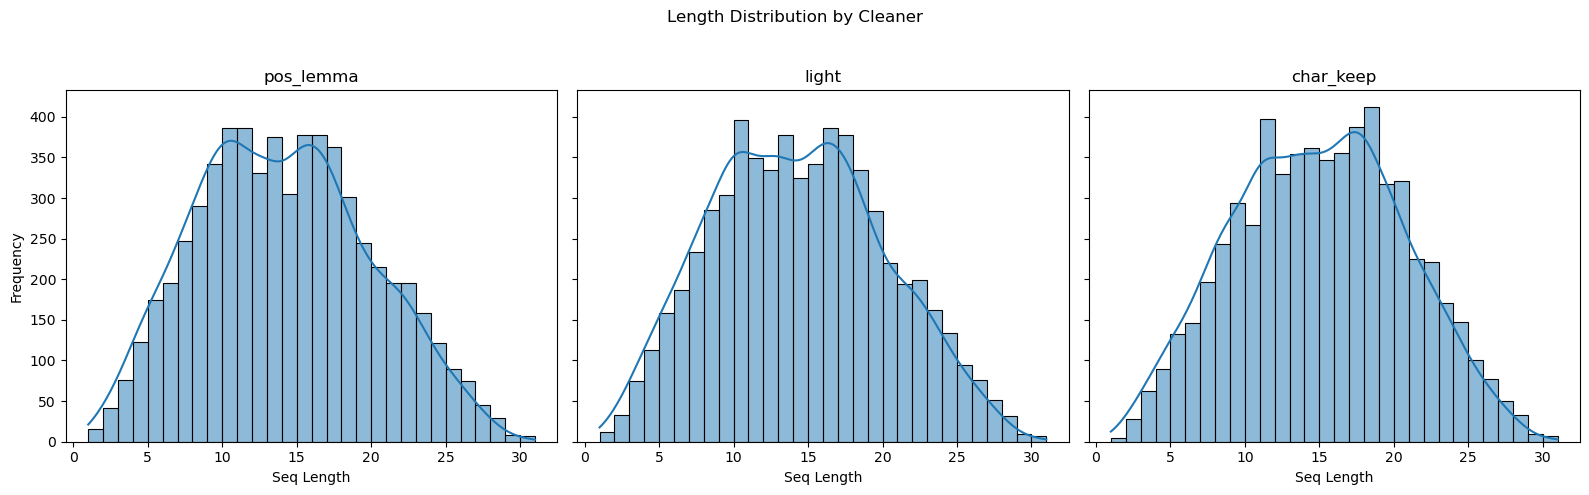

,pos_lemma,light,char_keep
min,1.0,1.0,1.0
1%,3.0,3.0,3.0
5%,5.0,5.0,5.0
10%,6.0,7.0,7.0
25%,10.0,10.0,11.0
50%,14.0,14.0,15.0
75%,18.0,18.0,19.0
90%,22.0,22.0,22.0
95%,24.0,24.0,24.0
99%,27.0,27.0,27.0


In [6]:
# Plot all cleaners' length distributions in a single horizontal subplot row,
# and tabulate all percentiles as columns.

fig, axes = plt.subplots(1, len(CLEANERS), figsize=(16,5), sharey=True)
percentile_stats = {}

PERCENTILES = [0.01, 0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99]

for idx, cleaner in enumerate(CLEANERS):
    split = disaster_data.get_split(cleaner)
    train_lengths = split['X_train'].str.split().str.len()

    # Save stats for table
    desc = train_lengths.describe(percentiles=PERCENTILES)
    # Get present percentiles exactly as indexed by pandas, avoiding the '100%' error
    present_labels = ['min']
    present_labels += [f"{int(p*100)}%" for p in PERCENTILES]
    present_labels += ['50%'] if '50%' not in present_labels else []
    if "max" in desc.index:
        present_labels += ['max']
    # filter only labels that actually exist
    present_labels = [lab for lab in present_labels if lab in desc.index]
    percentiles_only = desc.loc[present_labels]
    percentile_stats[cleaner] = percentiles_only

    # Plot
    ax = axes[idx]
    sns.histplot(train_lengths, bins=30, kde=True, ax=ax)
    ax.set_title(f'{cleaner}')
    ax.set_xlabel('Seq Length')
    if idx == 0:
        ax.set_ylabel('Frequency')
    else:
        ax.set_ylabel('')

plt.suptitle('Length Distribution by Cleaner')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Combine percentile stats into a single DataFrame for display
percentile_table = pd.concat(percentile_stats, axis=1)
display(percentile_table)


**2. Vocab Size**

After the below analysis, 73% of words only appear once. This could be due to different tense, typos, elongated words, etc since this was done on the uncleaned text. We need to consider the trade-off between cleaning some of these singletons vs cleaning important, but rare, words.

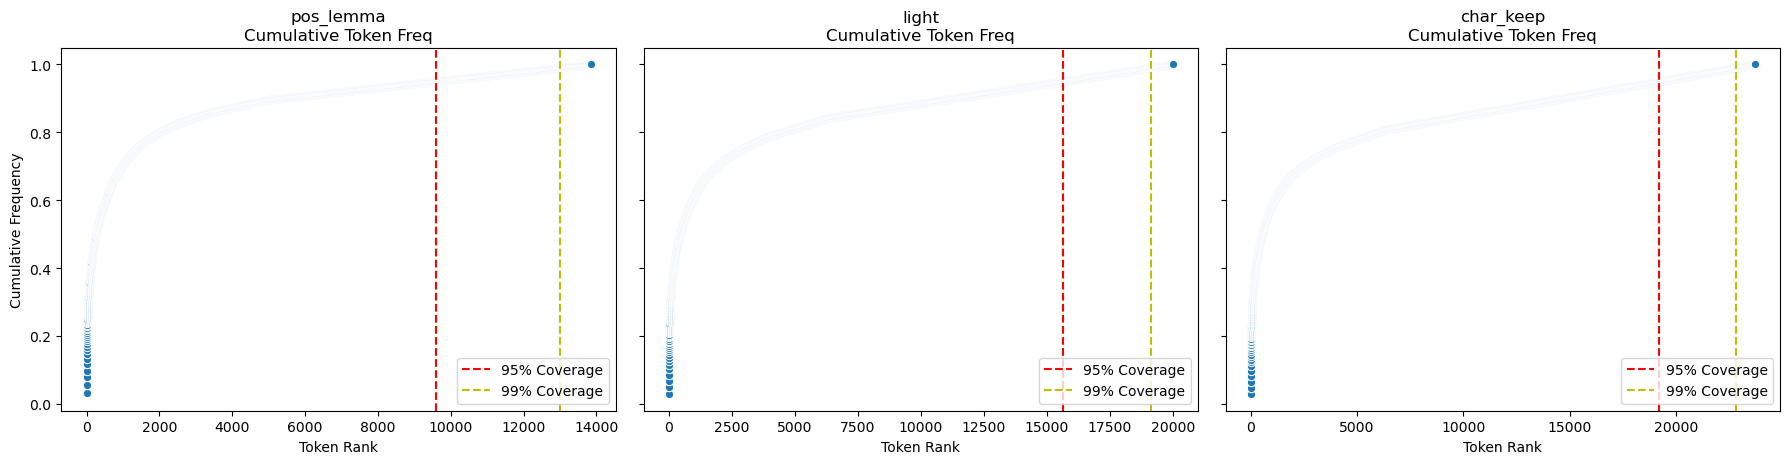

,pos_lemma,light,char_keep
Raw Vocabulary Size,13838,19994,23708
Words Appearing Once,8826,13653,17308
Percent Rare Words,63.78%,68.29%,73.00%
Words for 95% Mass,9585,15660,19185
Words for 99% Mass,12988,19128,22804


In [7]:
# Prepare for subplots and stats collection
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
vocab_stats = {}

for idx, cleaner in enumerate(CLEANERS):
    split = disaster_data.get_split(cleaner)
    vocab_counts = split['X_train'].str.split().explode().value_counts()
    vocab_size = len(vocab_counts)

    singletons = (vocab_counts == 1).sum()
    pct_rare = singletons / vocab_size
    cum_freq = vocab_counts.cumsum() / vocab_counts.sum()
    cutoff_95 = np.searchsorted(cum_freq.values, 0.95) + 1
    cutoff_99 = np.searchsorted(cum_freq.values, 0.99) + 1

    # Collect stats for DataFrame
    vocab_stats[cleaner] = {
        "Raw Vocabulary Size": vocab_size,
        "Words Appearing Once": singletons,
        "Percent Rare Words": f"{pct_rare:.2%}",
        "Words for 95% Mass": cutoff_95,
        "Words for 99% Mass": cutoff_99
    }

    # Plot on subplot
    ax = axes[idx]
    sns.lineplot(x=range(len(cum_freq)), y=cum_freq.values, marker='o', ax=ax)
    ax.set_title(f"{cleaner}\nCumulative Token Freq")
    ax.set_xlabel('Token Rank')
    if idx == 0:
        ax.set_ylabel('Cumulative Frequency')
    ax.axvline(cutoff_95, color='r', linestyle='--', label='95% Coverage')
    ax.axvline(cutoff_99, color='y', linestyle='--', label='99% Coverage')
    ax.legend(loc='lower right')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Display the stats as a DataFrame
vocab_table = pd.DataFrame(vocab_stats)
display(vocab_table)


**3. Embedding dimension & LSTM size**

We can't identify exactly the number of units to use via EDA, but I can:
1. Use the vocab size from #2 to estimate how many parameters we are training.
2. Keep the total parameter count in a reasonable range compared to the datset size.

After the analysis below, we will want to use smaller combinations to keep our total parameters lower. This is so we do not overfit the RNN model, our biggest lever for reducing parameters is actually reducing the number of words in our vocabulary. 

In [8]:
embedding_dim_range = [50, 100, 200]
lstm_units_range = [32, 64, 128]

param_stats = {}
for cleaner in CLEANERS:
    split = disaster_data.get_split(cleaner)
    vocab_range = [vocab_stats[cleaner]['Words for 95% Mass'], vocab_stats[cleaner]['Words for 99% Mass']]
    print(f"Vocab range for {cleaner}: {vocab_range}")
    for vocab_size in vocab_range:
        for ed in embedding_dim_range:
            for lu in lstm_units_range:
                embedding_params = vocab_size * ed
                lstm_params = 4 * lu * (lu + ed + 1)
                total_params = embedding_params + lstm_params
                id = hashlib.md5(f"{cleaner}_{vocab_size}_{ed}_{lu}".encode()).hexdigest()
                param_stats[id] = {
                    'Cleaner': cleaner,
                    'Vocab size': vocab_size,
                    'Embedding dim': ed,
                    'LSTM units': lu,
                    'Embedding params': embedding_params,
                    'LSTM params': lstm_params,
                    'Total params': total_params
                }
                # print(f"Embedding dim: {ed}, LSTM units: {lu}")
param_table = pd.DataFrame(param_stats)
display(param_table)


Vocab range for pos_lemma: [np.int64(9585), np.int64(12988)]
Vocab range for light: [np.int64(15660), np.int64(19128)]
Vocab range for char_keep: [np.int64(19185), np.int64(22804)]


,72e74475b7f6ee379d4dd30515d20509,77de4b9d6b136ef7e4bd661b2fc22a85,963a9fa751024f803b2ffb3af7650580,6f497d9b2e86df5bcaa3c65e1156096c,2dd40a9df77603a8ae2fb74becd5e3e6,05517ea8e0dd45521a3026e510efb64c,261357451523d4a01ca5942b27036ac0,69195e2d13113db95fb8fec5e3ba90b0,91e11a60c2167fcc32871c95dcba055c,2d413fe8b1ea4be6a7898bcf4a7979b6,...,09d6f66c51e5ac30b51bfeaf529110ef,1d8c27b8670f63079957f7584d9f247c,d80078543cfc3de86f761e2cab49fe2e,44f6ae1f7cb34210b4bb12a626b78fcd,1b7feee9c5c34036ef65b8ce8e16feef,36f97cd7e8112f43379ce80d5cf77c33,9970d944d1f856831a5d676b5269be30,8b8f5e52f7a973e2cb0c5f1f9be7d12d,10916870bd91361f9d202051f61dc0ce,73c75b50e16eed2bb64e93bdbd3a304d
Cleaner,pos_lemma,pos_lemma,pos_lemma,pos_lemma,pos_lemma,pos_lemma,pos_lemma,pos_lemma,pos_lemma,pos_lemma,...,char_keep,char_keep,char_keep,char_keep,char_keep,char_keep,char_keep,char_keep,char_keep,char_keep
Vocab size,9585,9585,9585,9585,9585,9585,9585,9585,9585,12988,...,19185,22804,22804,22804,22804,22804,22804,22804,22804,22804
Embedding dim,50,50,50,100,100,100,200,200,200,50,...,200,50,50,50,100,100,100,200,200,200
LSTM units,32,64,128,32,64,128,32,64,128,32,...,128,32,64,128,32,64,128,32,64,128
Embedding params,479250,479250,479250,958500,958500,958500,1917000,1917000,1917000,649400,...,3837000,1140200,1140200,1140200,2280400,2280400,2280400,4560800,4560800,4560800
LSTM params,10624,29440,91648,17024,42240,117248,29824,67840,168448,10624,...,168448,10624,29440,91648,17024,42240,117248,29824,67840,168448
Total params,489874,508690,570898,975524,1000740,1075748,1946824,1984840,2085448,660024,...,4005448,1150824,1169640,1231848,2297424,2322640,2397648,4590624,4628640,4729248


**4. OOV rate**

In [17]:
# OOV Rate with chosen num_words
def oov_rate(num_words, cleaner='light'):
    split = disaster_data.get_split(cleaner)
    tok = Tokenizer(num_words=num_words, oov_token='<OOV>')
    tok.fit_on_texts(split['X_train'])
    oov_id = tok.word_index['<OOV>']
    seqs = tok.texts_to_sequences(split['X_val'])
    total = sum(len(s) for s in seqs)
    oov = sum(sum(1 for t in s if t == oov_id) for s in seqs)
    return oov / total

nws = [5000, 10000, 12000, 15000, cutoff_95, cutoff_99]
for cl in CLEANERS:
    for nw in nws:
        print(nw, ' - ', cl, f'{oov_rate(nw, cl):.3%}')

5000  -  pos_lemma 14.610%
10000  -  pos_lemma 12.345%
12000  -  pos_lemma 11.408%
15000  -  pos_lemma 10.675%
19185  -  pos_lemma 10.675%
22804  -  pos_lemma 10.675%
5000  -  light 17.454%
10000  -  light 14.330%
12000  -  light 13.329%
15000  -  light 11.994%
19185  -  light 11.714%
22804  -  light 11.714%
5000  -  char_keep 18.543%
10000  -  char_keep 16.142%
12000  -  char_keep 15.671%
15000  -  char_keep 14.716%
19185  -  char_keep 13.529%
22804  -  char_keep 13.475%


## TF-IDF Preprocessing + LogReg Baseline

In [10]:
# Baseline model runner
def run_tfidf_logreg(data, tfidf_cfg, logreg_cfg, threshold=None):
    vec = TfidfVectorizer(**tfidf_cfg)
    Xtr = vec.fit_transform(data['X_train'])
    Xval = vec.transform(data['X_val'])

    model = LogisticRegression(**logreg_cfg)
    model.fit(Xtr, data['y_train'])

    val_probs = model.predict_proba(Xval)[:, 1]
    if threshold is None:
        grid = np.linspace(0.3, 0.7, 11)
        f1s = [f1_score(data['y_val'], (val_probs >= t).astype(int)) for t in grid]
        threshold = grid[int(np.argmax(f1s))]
    val_pred = (val_probs >= threshold).astype(int)
    val_f1 = f1_score(data['y_val'], val_pred)
    return {'val_f1': val_f1, 'threshold': threshold, 'model': model, 'vectorizer': vec}

In [11]:
# Define experiment config and grid
base = {
    'cleaner': 'light',
    'tfidf': {'max_features': 20000, 'ngram_range': (1,2), 'analyzer': 'word'},
    'logreg': {'C': 2.0, 'penalty': 'l2', 'max_iter': 1000, 'class_weight': 'balanced', 'n_jobs': -1},
}
grid = [
    base,
    {**base, 'cleaner': 'char_keep', 'tfidf': {**base['tfidf'], 'analyzer': 'char', 'ngram_range': (3,5)}},
    {**base, 'cleaner': 'pos_lemma'},
]

results = []
artifacts = {}
for cfg in grid:
    split = disaster_data.get_split(cfg['cleaner'])
    res = run_tfidf_logreg(split, cfg['tfidf'], cfg['logreg'])
    name = f"{cfg['cleaner']}_{cfg['tfidf']['analyzer']}_{cfg['tfidf']['ngram_range']}"
    results.append({'name': name, 'val_f1': res['val_f1'], 'threshold': res['threshold']})
    artifacts[name] = (res, split, cfg)

pd.DataFrame(results).sort_values('val_f1', ascending=False)

,name,val_f1,threshold
2,"pos_lemma_word_(1, 2)",0.777117,0.46
1,"char_keep_char_(3, 5)",0.771359,0.54
0,"light_word_(1, 2)",0.767286,0.46


In [12]:
best_name = pd.DataFrame(results).sort_values('val_f1', ascending=False).iloc[0]['name']
res, split, cfg = artifacts[best_name]

# Refit on full train (train+val) with same cleaner/vectorizer settings
full_clean = pd.concat([split['X_train'], split['X_val']])
full_y = pd.concat([split['y_train'], split['y_val']])

vec = TfidfVectorizer(**cfg['tfidf'])
Xfull = vec.fit_transform(full_clean)
model = LogisticRegression(**cfg['logreg'])
model.fit(Xfull, full_y)

Xtest = vec.transform(split['X_test'])
test_pred = (model.predict_proba(Xtest)[:,1] >= res['threshold']).astype(int)

print(f'Best model: {best_name}')
print(f'F1 Score: {res["val_f1"]:.4f}')
print(f'Threshold: {res["threshold"]:.4f}')

# No baseline submission

Best model: pos_lemma_word_(1, 2)
F1 Score: 0.7771
Threshold: 0.4600


## RNN Model (Keras)

In [13]:
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(disaster_data.train_df['text'])

X_train_seq = tokenizer.texts_to_sequences(disaster_data.train_df['text'])
X_val_seq = tokenizer.texts_to_sequences(disaster_data.val_df['text'])
X_test_seq = tokenizer.texts_to_sequences(disaster_data.test_df['text'])

maxlen = 32

X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_val_pad = pad_sequences(X_val_seq, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

vocab_size = min(10000, len(tokenizer.word_index) + 1)
embedding_dim = 50
lstm_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(LSTM(lstm_units, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model.summary()

/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-12-08 19:19:26.598690: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-12-08 19:19:26.598710: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:160] env: CUDA_VISIBLE_DEVICES="-1"
2025-12-08 19:19:26.598713: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-12-08 19:19:26.598714: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-12-08 19:19:26.598717: I external/local_

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    X_train_pad, disaster_data.train_df['target'],
    epochs=3,
    batch_size=64,
    validation_data=(X_val_pad, disaster_data.val_df['target']),
    )

val_pred_prob = model.predict(X_val_pad).ravel()
val_pred = (val_pred_prob >= 0.5).astype(int)
val_f1_rnn = f1_score(disaster_data.y_val, val_pred)
print(f'LSTM F1 Score: {val_f1_rnn:.4f}')

Epoch 1/3


2025-12-08 19:19:27.238959: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: indices[56,9] = 16006 is not in [0, 10000)
	 [[{{function_node __inference_one_step_on_data_2744}}{{node sequential_1/embedding_1/GatherV2}}]]


InvalidArgumentError: Graph execution error:

Detected at node sequential_1/embedding_1/GatherV2 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 758, in start

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 614, in shell_main

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_shell

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 366, in execute_request

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 827, in execute_request

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 458, in do_execute

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 663, in run_cell

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3123, in run_cell

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3178, in _run_cell

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3400, in run_cell_async

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3641, in run_ast_nodes

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3701, in run_code

  File "/tmp/ipykernel_5468/1821540694.py", line 1, in <module>

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 399, in fit

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 241, in function

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 154, in multi_step_on_iterator

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 125, in wrapper

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 134, in one_step_on_data

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 59, in train_step

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/layers/layer.py", line 941, in __call__

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/ops/operation.py", line 59, in __call__

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/models/sequential.py", line 220, in call

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/models/functional.py", line 183, in call

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/ops/function.py", line 206, in _run_through_graph

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/models/functional.py", line 644, in call

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/layers/layer.py", line 941, in __call__

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/ops/operation.py", line 59, in __call__

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/layers/core/embedding.py", line 158, in call

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/ops/numpy.py", line 6193, in take

  File "/home/buffalo/miniforge3/envs/school/lib/python3.12/site-packages/keras/src/backend/tensorflow/numpy.py", line 2589, in take

indices[56,9] = 16006 is not in [0, 10000)
	 [[{{node sequential_1/embedding_1/GatherV2}}]] [Op:__inference_multi_step_on_iterator_2799]

### Kaggle Submission

In [ ]:
test_pred_prob = model.predict(X_test_pad).ravel()
test_pred = (test_pred_prob >= 0.5).astype(int)

disaster_data.submission = pd.DataFrame({
    'id': disaster_data.test_df.id,
    'target': test_pred
})
disaster_data.submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


## Error Analysis

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

mis_idx = np.where(val_pred != disaster_data.y_val)[0][:3]

for i in mis_idx:
    text_i = disaster_data.X_val_raw.iloc[i]
    vec_i = X_val_tfidf[i]

    # find nearest neighbors in training set
    sims = cosine_similarity(vec_i, X_train_tfidf).ravel()
    top_idx = sims.argsort()[-3:][::-1]

    print('--- Misclassified Text ---')
    print('Text:', text_i)
    print('Pred:', val_pred[i])
    print('True:', disaster_data.y_val.iloc[i])
    print('Nearest Neighbors:')
    for idx in top_idx:
        print(f'Text: {disaster_data.X_train_raw.iloc[idx]}')
    print()

--- Misclassified Text ---
Text: @Blizzard_draco @LoneWolffur I need this.
Pred: 1
True: 0
Nearest Neighbors:
Text: @Blizzard_draco @LoneWolffur also me please I would very much like a link
Text: @LoneWolffur control yourself tora
Text: @LoneWolffur BRUH *dies*

--- Misclassified Text ---
Text: #news Politifiact: Harry Reid's '30 Percent of Women Served' Planned Parenthood Claim Is a 'Pants on Fire' Lie... http://t.co/bMSeDZOfSV
Pred: 1
True: 0
Nearest Neighbors:
Text: Politifiact: Harry Reid's '30 Percent of Women Served' Planned Parenthood Claim Is a 'Pants on Fire' Lie http://t.co/aMYMwWcpYm | #tcot
Text: 30 seconds for my bitches to evacuate ??????
Text: @NoahCRothman Bore him with minutiae serve bad champagne. He may just explode.

--- Misclassified Text ---
Text: @mustachemurse @dateswhitecoats the truth. I pulled a 16 out. And apparently a 22 in the crazy adult trauma. And they mocked me for the 22.
Pred: 1
True: 0
Nearest Neighbors:
Text: SCREAMING IN 22 DIFFERENT LANGUAGES htt